In [49]:
%matplotlib inline


# Réseaux récurrents pour la classification de texte
D'après le tutoriel de
**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)

Reformulé pour le Master SID Université de Rouen Normandie, module Deep Learning, Thierry Paquet, 2023.

Nous construisons un réseau récurrent chargé de classer l'origine des noms de famille. Le dataset est constitué d'un ensemble de noms de famille Européens. Le réseau parcourt un nom de gauche à droite, caractère par caractère, et utilise son état interne à la fin du parcours pour classer le nom parmi 18 langues possibles.
Voici deux exemples de prédiction: 
    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


## Preparation des données

Le fichier de prénoms est chargé à partir de ce lien 
   [https://download.pytorch.org/tutorial/data.zip](https://download.pytorch.org/tutorial/data.zip) et décompressé dans le répertoire courant.

Dans le répertoire ``data/names`` se trouvent 18 fichiers texte nommés 
"[Language].txt". Chaque fichier comprend un ensemble de noms, un par ligne, écrits avec des caractères Romains. Mais il subsiste des caractères spéciaux propres à certaines langues, que l'on va devoir normaliser. Une étape de pré-traitement est donc mise en oeuvre pour transformer les caractères UNICODE en ASCII.

Depuis votre machine locale, placer les 18 fichiers dans un répertoire ``data/names`` sous google drive. A l'intialisation de votre programme, vous crérez le répertoire drive puis monterez votre partition Drive dans votre environnement d'exécution Colab à l'aide des commandes ci-dessous.

## **Question 1:** Expliquez chaque étape de la méthode ```unicodeToAscii()```**

La fonction ```unicodeToAscii()``` normalise chaque caractere de la chaine s avec une normalisation de forme ``NFD`` ensuite on verifie si la n'est pas de la forme ``Mn` et qu'il fait partie de nos caractére

In [50]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print('Ślusàrski ToAscii',unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Ślusàrski ToAscii Slusarski


A present nous avons dans la variable ``category_lines``,  un dictionnaire des noms des langues qui permet d'accéder au listes de noms de chaque langue. On mémorise également dans la variable  ``all_categories`` la liste des noms des langues et dans ``n_categories`` le nombre de langues.




In [51]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Transformation en tenseurs

Il faut maintenant écrire les données dans des tenseurs. Chaque caractère va être encodé en un vecteur binaire dit "one-hot vector" de taille 
$<1 \times n_{letters}>$. Un vecteur one-hot est un vecteur binaire rempli de valeurs à 0 à l'exception d'une seule entrée mise à 1 correspondant à l'index du caractère représenté par ce vecteur, par exemple ``"b" = <0 1 0 0 0 ...>``.

Un mot est donc encodé par une séquence de vecteurs one-hot qui est placée dans un tenseur 2D de dimension $<line\_length \times 1 \times n_{letters}>$.

On insère une dimension suplémentaire de taille 1 parce que PyTorch manipule des lots (batch) - ici nous avons donc un batch de taille 1 exemple.


In [52]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
print('One hot vector de la lettre J:')
print(letterToTensor('J'))

print('Taille du tenseur encodant le mot "Jones":')
print(lineToTensor('Jones').size())

One hot vector de la lettre J:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
Taille du tenseur encodant le mot "Jones":
torch.Size([5, 1, 57])


## Creation de la classe réseau récurrent
Avant l'utilisation par Pytorch de l'autodifférentiation par la méthode  ``` autograd```, la création d'un réseau récurrent passait par la déclaration d'une couche qui se répétait sur plusieurs pas de temps consécutifs. Ces couches maintenaient l'état caché et le gradient rétropropagé au cours du temps.

Désormais, les couches récurrentes sont gérées par ```autograd``` qui construit pour nous le graphe de calcul du réseau déplié au cours du temps. Cela veut dire qu'un réseau récurrent est désormais déclaré comme un réseau feed-forward non récurrent, et que c'est autograd qui gère la structure récurrente lorsque le réseaux est instancié.

Le réseau récurrent que nous allons utiliser contient simplement deux couches `Linear()` qui voient toutes deux les données d'entrée constituées de l'entrée courante + la sortie précédente concaténées ```combined = torch.cat()```.

La première couche linéaire est de type feedforward suivie d'une activation softmax. Elle produit la sortie courante. 
La seconde couche est récurrente. Elle produit l'état caché de la couche récurrente à travers une couche linéaire. L'ensemble est schématisé sur cette figure: <img src="https://i.imgur.com/Z2xbySO.png"></img>


In [53]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Pour faire une itération avec ce réseau il faut lui fournir une entrée (dans notre cas le one-hot vector qui encode le caractère courant et l'état précédent du réseau (initialisé à zéro à la première itération). 
Le réseau fournit en retour le vecteur de probabilité de chaque langue et l'état caché courant (que l'on va utiliser pour l'itération suivante).

In [54]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

Pour être plus efficace on ne crée pas un nouveau tenseur pour chaque nouveau caractère d'entrée. 
A la place, on crée un seul tenseur pour toute la séquence de caractères. On utilise  `` input = lineToTensor`` au lieu de ``letterToTensor`` et on itère sur toutes les positions du tenseur de la séquence d'entrée. 

## **Question 2:** Expliquez chaque étape de la méthode ```lineToTensor()``` 
La methode ```lineToTensor()``` permet de creer une one hote vector pour chaque caractére du texte passé en parametre et mettre ses vecteurs sous forme de tenseur
## **Question 3:** Que représente le tenseur ```output``` ?
Le tenseur ```output``` represente la valeur du ``log softmax`` de chaque langue c'est à dire la sortie de notre fonction softmax

In [55]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9309, -2.9205, -2.8589, -2.8099, -2.8434, -2.9184, -2.9483, -2.8637,
         -3.0344, -2.9358, -2.8677, -2.8786, -2.9073, -2.8917, -2.8378, -2.8549,
         -2.8885, -2.8586]], grad_fn=<LogSoftmaxBackward0>)


## Entrainement du réseau
Préparer l'entrainement
----------------------

On déclare quelques fonctions qui vont nous aider. La première va nous permettre de mieux visualiser la sortie courante du réseau. On utilise pour cela la méthode ``categoryFromOutput()``.

## **Question 4:** Expliquez chaque ligne de la méthode ``categoryFromOutput()``
``top_n, top_i = output.topk(1)`` : On recupere deux tenseurs (top_n, top_i) qui stocke respectivement la plus grande valeur et l'indexe correspondant du tenseur output.
``category_i = top_i[0].item()`` : On recure la valeur stocké par le tenseur (un entier) 
``all_categories[category_i], category_i``: On retourne le pays et le numero associé

In [56]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 3)


On a également besoin de visualiser un exemple d'apprentissage (un nom et sa langue).

## **Question 5:** Que réalise la fonction ``` randomTrainingExample()``` ?


## La fonction randomTrainingExample() est utilisée pour sélectionner aléatoirement un exemple d'entraînement à partir d'un ensemble de données organisées par catégories
## all_categories est une liste contenant les différentes catégories disponibles.randomChoice(all_categories) choisit une catégorie au hasard. category_lines est un dictionnaire où chaque clé est une catégorie et chaque valeur est une liste de chaînes de caractères associées à cette catégorie. randomChoice(category_lines[category]) choisit une ligne aléatoire dans la liste des exemples de la catégorie sélectionnée.

In [57]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # print('category =', category, '/ line =', line)

### Entrainer le réseau

Maintenant il suffit de présenter au réseau un lot d'apprentissage pour qu'il fasse une prédiction et qu'il adapte ses poids en fonction de ses erreurs.
Puisque la fonction d'activation de sortie est une `nn.LogSoftmax`, le critère d'apprentissage choisi est  `nn.NLLLoss`.


## **Question 6:** A quoi correspond le critère pytorch `nn.NLLLoss` ?

## Le critère torch.nn.NLLLoss (Negative Log-Likelihood Loss) est une fonction de perte utilisée principalement pour des tâches de classification dans PyTorch. Elle est généralement utilisée en combinaison avec nn.LogSoftmax pour entraîner des modèles de classification.

In [58]:
criterion = nn.NLLLoss()

Chaque époque de la boucle d'apprentissage fait appel à la méthode `train()`

## **Question 7:** expliquez toutes les étapes de la méthode `train()` 
Préciser
- la taille des lots
- l'optimiseur utilisé

Proposez quelques améliorations possibles de cette méthode

## La méthode train() entraîne le réseau de neurones récurrent  en mettant à jour ses poids à l’aide de la descente de gradient, en utilisant un optimiseur et une taille de lot spécifique.
La méthode prend en entrée :
### category_tensor : un tenseur représentant la vraie catégorie sous forme d’un index 
### line_tensor : un tenseur représentant une séquence d’entrée (ex : un mot ou un nom encodé en caractères).
### hidden = rnn.initHidden():Initialisation de l’état caché
### rnn.zero_grad() : Remise à zéro des gradients
### output, hidden = rnn(line_tensor[i], hidden) : Passage avant (Forward pass)
### loss = criterion(output, category_tensor): Calcul de la perte (Loss computation)
### loss.backward(): Rétropropagation des erreurs
### p.data.add_(p.grad.data, alpha=-learning_rate):Mise à jour des poids avec l’optimiseur

Taille des lots=1
Optimiseur = SGD
## Pour améliorer l'entraînement :

    -Augmenter la taille du lot (batch_size > 1).

    -Utiliser un optimiseur moderne (torch.optim.Adam).

    -Ajouter de la régularisation (dropout, weight decay).

    -Expérimenter avec différentes architectures de RNN (LSTM, GRU).

In [59]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Maintenant il suffit simplement de lancer l'exécution de l'apprentissage sur l'ensemble des exemples. 

## **Question 8 :** expliquer la structure de la boucle principale du programme
Précisez notamment les variables mémorisées et visualisées

## Étapes de la boucle principale
### Génération d’un exemple aléatoire c'est à dire sélectionne un nom et sa catégorie
### Entraînement du modèle c'est à dire	passe l’exemple dans train() et récupère la perte
### Accumulation de la pertec'est à dire ajoute loss à current_loss
### Affichage périodique (print_every) c'est à dire les performances actuelles du modèle
### Enregistrement des pertes (plot_every) stocke la perte moyenne pour analyse graphique
## Variable mémorisé
### n_iters:	Nombre total d’itérations d'entraînement
### print_every:	Fréquence d'affichage des résultats
### plot_every:	Fréquence d'enregistrement des pertes
### current_loss:	Somme des pertes sur plot_every itérations
### all_losses:	Liste des pertes moyennes stockées pour visualisation
### start:	Timestamp du début de l'entraînement
### category:	Catégorie réelle de l’exemple sélectionné
### line:	Séquence d’entrée (ex : un nom)
### category_tensor:	Encodage tensoriel de la catégorie
### line_tensor:	Encodage tensoriel de la séquence d’entrée
### output:	Prédiction du modèle (scores des catégories)
### loss:	Erreur du modèle sur cet exemple
### guess:	Catégorie prédite par le modèle
### correct:	Indicateur de succès 

In [60]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 3.1333 Guirguis / Greek ✗ (Arabic)
10000 10% (0m 5s) 1.6882 Haptakhaev / Russian ✓
15000 15% (0m 8s) 1.8705 Shenyavsky / Polish ✗ (Russian)
20000 20% (0m 10s) 0.8955 Chong / Chinese ✓
25000 25% (0m 13s) 0.9257 Lam / Vietnamese ✓
30000 30% (0m 15s) 3.4586 See / Korean ✗ (Dutch)
35000 35% (0m 18s) 0.8065 Faolan / Irish ✓
40000 40% (0m 21s) 1.6947 Szwedko / Japanese ✗ (Polish)
45000 45% (0m 23s) 2.0631 Birch / German ✗ (English)
50000 50% (0m 26s) 0.6502 Kuipers / Dutch ✓
55000 55% (0m 29s) 0.5785 Que / Chinese ✓
60000 60% (0m 31s) 2.3301 Deniaud / Arabic ✗ (French)
65000 65% (0m 34s) 1.0963 Haenraats / Dutch ✓
70000 70% (0m 37s) 1.8378 Krauss / Arabic ✗ (German)
75000 75% (0m 39s) 0.3140 Morandi / Italian ✓
80000 80% (0m 42s) 0.2577 Byon / Korean ✓
85000 85% (0m 45s) 0.5113 Tan / Chinese ✓
90000 90% (0m 47s) 3.5119 Aonghuis / Dutch ✗ (Irish)
95000 95% (0m 50s) 0.4247 Bologna / Italian ✓
100000 100% (0m 53s) 3.8893 Derjavets / Dutch ✗ (Russian)


### Affichage des résultats

On visualise l'évolution du critère ``all_losses`` au cours de l'apprentissage:


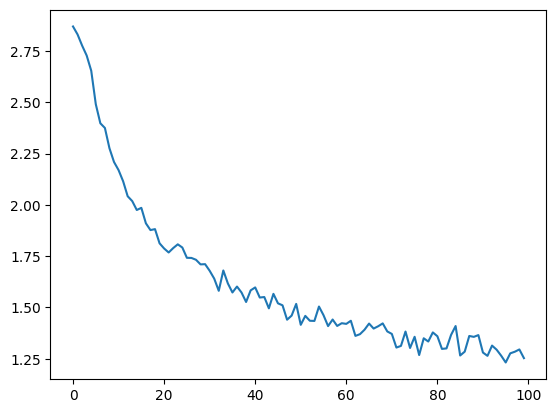

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluation des performances
Pour une première évaluation des capacités du réseau on calcule la matrice de confusion. 

## **Question 9:** Préciser le rôle de la fonction `evaluate()`
  La fonction evaluate() est utilisée pour évaluer le modèle RNN  sur une séquence d'entrée donnée, et elle retourne la prédiction du modèle pour cette séquence. Elle  permet d’obtenir la prédiction du modèle pour une entrée donnée en traitant chaque élément de la séquence dans le RNN et en renvoyant la sortie du modèle après avoir vu toute la séquence
## **Question 10:** Quel est le principal défaut de cette évaluation ?
Le principal défaut de la fonction réside dans le fait qu'elle ne calcule pas de mesure de performance sur la prédiction par rapport à une véritable étiquette ou valeur cible. En d'autres termes, elle renvoie uniquement la prédiction du modèle sans évaluer si cette prédiction est correcte ou non.

## **Question 11:** Quelles sont les langues les moins bien identifiées? Quelles sont les principales confusions ? 
 Les langues avec peu de données d'entraînement ou des noms peu représentés peuvent rendre l'identification de ces langues plus difficile.
 Les confusions surviennent lorsque des langues partagent des caractéristiques similaires, ce qui entraîne une mauvaise classification du modèle

/tmp/ipykernel_6242/4223549400.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_6242/4223549400.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


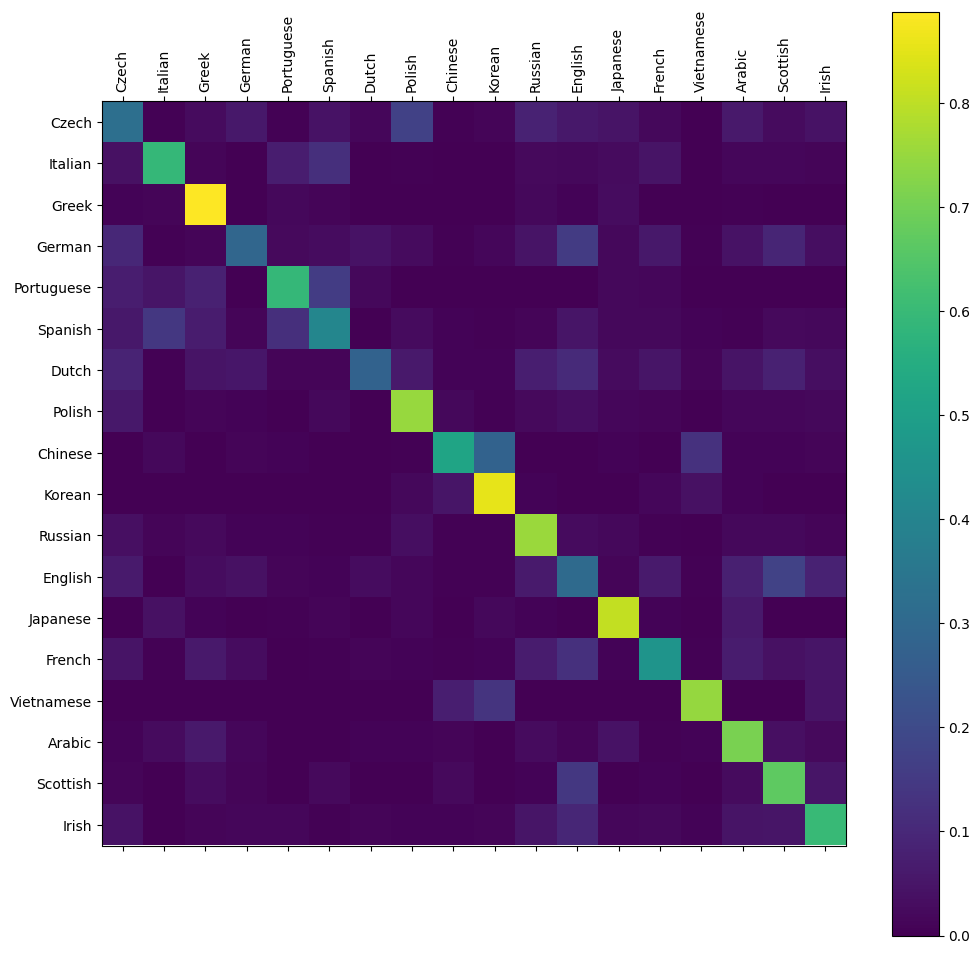

In [62]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Exécution sur vos prropres exemples

## **Question 12:** Expliquer les différentes étapes de la méthode `predict()`
La fonction predict() permet de prédire les n catégories les plus probables pour une entrée donnée (par exemple, un nom). Elle prend en entrée une chaîne de caractères (comme un nom) et retourne les n_predictions (par défaut 3) catégories les plus probables en fonction de l'output du modèle.
### Désactivation du calcul des gradients : with torch.no_grad():
### Évaluation de l'entrée : output = evaluate(lineToTensor(input_line))
### Récupération des N meilleures catégories : topv, topi = output.topk(n_predictions, dim=1, largest=True)
### Construction de la liste des prédictions 
### Retour des prédictions


In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, dim=1, largest=True)
        # largest: controls whether to return largest or smallest elements
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
print('NIANG')


> Dovesky
(-0.51) Russian
(-1.10) Czech
(-3.48) Polish

> Jackson
(-0.43) Scottish
(-1.50) English
(-2.87) Russian

> Satoshi
(-0.85) Japanese
(-1.61) Polish
(-2.15) Italian
NIANG


## Exercices supplémentaires

-  Améliorer les résultats en envisageant une évolution de l'architecture du réseau

   -  ajouter plus de couches linéaires
   -  empiler  plusieurs couches récurrentes
   
-  Extensions possibles : envisager d'autres tâches similaires telles que:
   -  Déduire le genre des prénoms
   -  Classer des lignes de texte parmi Titre / plein texte / légende etc... 



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(RNN2, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM empilé avec plusieurs couches
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Ajouter plusieurs couches linéaires pour améliorer les capacités de représentation
        self.fc1 = nn.Linear(hidden_size, 256)  # Couches plus larges
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)  # Dernière couche pour la classification
        
        # Fonction softmax pour normaliser la sortie
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_seq):
        # Initialisation de l'état caché et de la cellule pour LSTM
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(input_seq.device)

        # Passage à travers le LSTM empilé
        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # Prendre la sortie de la dernière étape de la séquence
        hidden = lstm_out[:, -1, :]

        # Passer à travers les couches linéaires supplémentaires
        x = F.relu(self.fc1(hidden))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.fc4(x)
        
        # Appliquer le softmax pour obtenir les probabilités des catégories
        output = self.softmax(output)
        
        return output
